LightGBM not available. Install with: pip install lightgbm
CatBoost not available. Install with: pip install catboost
Creating base dataset...
Base dataset saved as 'rwanda_crop_water_requirements_base.csv'
Creating adjusted dataset...
Adjusted dataset saved as 'rwanda_crop_water_requirements_adjusted.csv'

Starting model comparison...
Creating comprehensive dataset...
Dataset created with 7600 samples and 13 features

Evaluating 9 models...
Training Random Forest...
Training Extra Trees...
Training Gradient Boosting...
Training Ridge...
Training Lasso...
Training ElasticNet...
Training Decision Tree...
Training XGBoost...
Training Ensemble...
Evaluation complete!

Detailed Model Results:
--------------------------------------------------------------------------------

XGBoost:
  R² Score: 0.9962
  RMSE: 69.06
  MAE: 35.44
  Cross-validation R² (mean ± std): 0.9945 ± 0.0014

Gradient Boosting:
  R² Score: 0.9959
  RMSE: 71.90
  MAE: 35.70
  Cross-validation R² (mean ± std): 0.9939 ± 0.

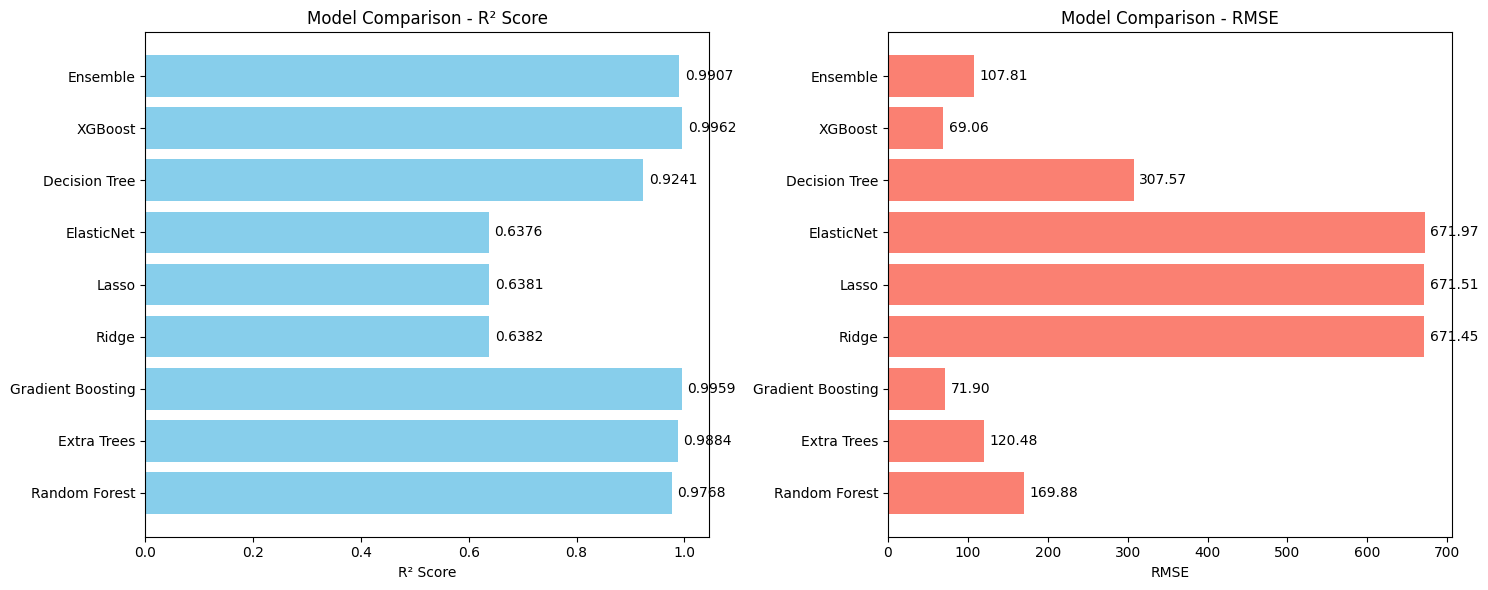

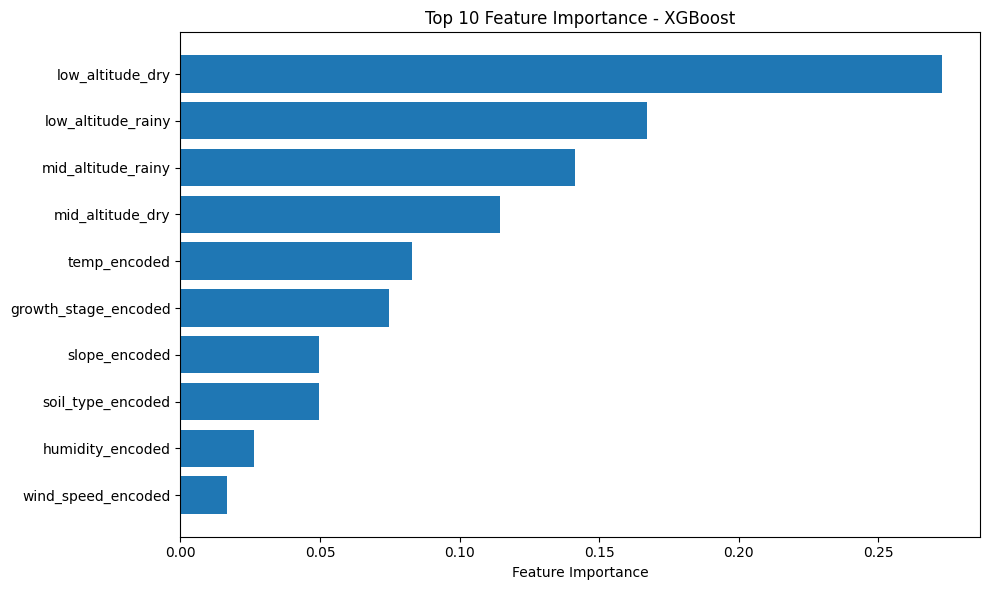


Best model saved as: best_model_xgboost.joblib


In [27]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available. Install with: pip install catboost")
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dataset for agricultural water requirements
rwanda_agricultural_data = {
    'crops': [
        'Maize', 'Rice', 'Sorghum', 'Wheat', 'Millet', 
        'Cassava', 'Sweet Potatoes', 'Irish Potatoes', 'Yams', 'Taro',
        'Beans', 'Soybeans', 'Groundnuts', 'Peas', 'Green Grams',
        'Coffee', 'Tea', 'Pyrethrum', 'Sugarcane', 'Cotton',
        'Banana', 'Avocado', 'Mango', 'Pineapple', 'Passion Fruit', 'Tree Tomato',
        'Tomatoes', 'Cabbage', 'Carrots', 'Onions', 'Green Peppers', 'Eggplant',
        'Sunflower', 'Palm Oil', 'Macadamia', 'Ginger', 'Chili Peppers', 'Vanilla'
    ],
    
    'base_water_requirements': {
        'low_altitude': {  # Eastern Province (1000-1500m)
            'dry_season': [650, 1200, 450, 450, 400, 900, 550, 600, 750, 800, 400, 450, 500, 350, 380, 1600, 2000, 700, 1800, 900, 1800, 800, 1000, 1200, 900, 850, 400, 380, 400, 350, 600, 450, 600, 1200, 900, 800, 500, 900],
            'rainy_season': [455, 840, 315, 315, 280, 630, 385, 420, 525, 560, 280, 315, 350, 245, 266, 1120, 1400, 490, 1260, 630, 1260, 560, 700, 840, 630, 595, 280, 266, 280, 245, 420, 315, 420, 840, 630, 560, 350, 630]
        },
        'mid_altitude': {  # Central and Southern Provinces (1500-2000m)
            'dry_season': [600, 1100, 400, 425, 375, 850, 500, 550, 700, 750, 375, 425, 475, 325, 355, 1500, 1900, 650, 1700, 850, 1700, 750, 950, 1150, 850, 800, 375, 355, 375, 325, 550, 425, 550, 1150, 850, 750, 475, 850],
            'rainy_season': [420, 770, 280, 298, 263, 595, 350, 385, 490, 525, 263, 298, 333, 228, 249, 1050, 1330, 455, 1190, 595, 1190, 525, 665, 805, 595, 560, 263, 249, 263, 228, 385, 298, 385, 805, 595, 525, 333, 595]
        },
        'high_altitude': {  # Northern and Western Provinces (>2000m)
            'dry_season': [550, 1000, 350, 400, 350, 800, 450, 500, 650, 700, 350, 400, 450, 300, 330, 1400, 1800, 600, 1600, 800, 1600, 700, 900, 1100, 800, 750, 350, 330, 350, 300, 500, 400, 500, 1100, 800, 700, 450, 800],
            'rainy_season': [385, 700, 245, 280, 245, 560, 315, 350, 455, 490, 245, 280, 315, 210, 231, 980, 1260, 420, 1120, 560, 1120, 490, 630, 770, 560, 525, 245, 231, 245, 210, 350, 280, 350, 770, 560, 490, 315, 560]
        }
    },
    
    'soil_type_adjustments': {
        'sandy': 1.3, 'loamy': 1.0, 'clay': 0.8, 'silty': 0.9, 'peaty': 0.7
    },
    
    'slope_adjustments': {
        '0-5': 1.0, '5-10': 1.2, '10-15': 1.4, '>15': 1.6
    },
    
    'critical_growth_stages': {
        'germination': 1.2, 'vegetative': 1.0, 'flowering': 1.5, 'fruit_development': 1.3, 'maturity': 0.7
    },
    
    'environmental_factors': {
        'temperature_adjustment': {'<15': 0.8, '15-25': 1.0, '25-30': 1.2, '>30': 1.4},
        'humidity_adjustment': {'<40': 1.3, '40-60': 1.1, '60-80': 1.0, '>80': 0.9},
        'wind_speed_adjustment': {'<2': 1.0, '2-5': 1.1, '5-8': 1.2, '>8': 1.3}
    }
}

def create_base_dataset():
    """Create the base dataset with water requirements"""
    df = pd.DataFrame({
        'crop': rwanda_agricultural_data['crops'],
        'low_altitude_dry': rwanda_agricultural_data['base_water_requirements']['low_altitude']['dry_season'],
        'low_altitude_rainy': rwanda_agricultural_data['base_water_requirements']['low_altitude']['rainy_season'],
        'mid_altitude_dry': rwanda_agricultural_data['base_water_requirements']['mid_altitude']['dry_season'],
        'mid_altitude_rainy': rwanda_agricultural_data['base_water_requirements']['mid_altitude']['rainy_season'],
        'high_altitude_dry': rwanda_agricultural_data['base_water_requirements']['high_altitude']['dry_season'],
        'high_altitude_rainy': rwanda_agricultural_data['base_water_requirements']['high_altitude']['rainy_season']
    })
    return df

def calculate_adjusted_water(df, soil_type='loamy', slope='0-5', temp='15-25', humidity='60-80', wind_speed='<2', growth_stage='vegetative'):
    """Calculate adjusted water requirements"""
    # Get adjustment factors
    soil_factor = rwanda_agricultural_data['soil_type_adjustments'][soil_type]
    slope_factor = rwanda_agricultural_data['slope_adjustments'][slope]
    temp_factor = rwanda_agricultural_data['environmental_factors']['temperature_adjustment'][temp]
    humidity_factor = rwanda_agricultural_data['environmental_factors']['humidity_adjustment'][humidity]
    wind_factor = rwanda_agricultural_data['environmental_factors']['wind_speed_adjustment'][wind_speed]
    growth_factor = rwanda_agricultural_data['critical_growth_stages'][growth_stage]
    
    total_adjustment = soil_factor * slope_factor * temp_factor * humidity_factor * wind_factor * growth_factor
    
    # Apply adjustments to all water requirement columns
    adjusted_df = df.copy()
    for col in df.columns:
        if col.endswith(('dry', 'rainy')):
            adjusted_df[f'{col}_adjusted'] = df[col] * total_adjustment
    
    return adjusted_df

class CropWaterRequirementModelComparison:
    def __init__(self):
        # Optimized models for agricultural tabular data
        self.models = {
            # Tree-based ensemble methods (best for agricultural data)
            'Random Forest': RandomForestRegressor(
                n_estimators=200, 
                max_depth=15, 
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42
            ),
            'Extra Trees': ExtraTreesRegressor(
                n_estimators=200,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=6,
                random_state=42
            ),
            
            # Regularized linear models (good baselines)
            'Ridge': Ridge(alpha=1.0, random_state=42),
            'Lasso': Lasso(alpha=0.1, random_state=42),
            'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
            
            # Simple tree (interpretable baseline)
            'Decision Tree': DecisionTreeRegressor(
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=42
            )
        }
        
        # Add advanced models if available
        if XGBOOST_AVAILABLE:
            self.models['XGBoost'] = xgb.XGBRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbosity=0
            )
            
        if LIGHTGBM_AVAILABLE:
            self.models['LightGBM'] = lgb.LGBMRegressor(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbosity=-1
            )
            
        if CATBOOST_AVAILABLE:
            self.models['CatBoost'] = cb.CatBoostRegressor(
                iterations=200,
                learning_rate=0.1,
                depth=6,
                random_state=42,
                verbose=False
            )
        
        # Create ensemble of best tree models
        base_models = [
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42)),
            ('et', ExtraTreesRegressor(n_estimators=100, random_state=42))
        ]
        
        if XGBOOST_AVAILABLE:
            base_models.append(('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)))
            
        self.models['Ensemble'] = VotingRegressor(base_models)
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.best_model = None
        self.best_model_name = None
        self.best_score = -np.inf
        self.feature_names = None
        self.results = {}

    def create_comprehensive_dataset(self):
        """Create a comprehensive dataset with multiple scenarios"""
        base_df = create_base_dataset()
        
        # Create multiple scenarios with different conditions
        scenarios = []
        soil_types = ['sandy', 'loamy', 'clay', 'silty', 'peaty']
        slopes = ['0-5', '5-10', '10-15', '>15']
        temps = ['<15', '15-25', '25-30', '>30']
        humidities = ['<40', '40-60', '60-80', '>80']
        wind_speeds = ['<2', '2-5', '5-8', '>8']
        growth_stages = ['germination', 'vegetative', 'flowering', 'fruit_development', 'maturity']
        
        # Create a subset of combinations to avoid too many rows
        np.random.seed(42)
        for _ in range(200):  # Create 200 different scenarios
            scenario = {
                'soil_type': np.random.choice(soil_types),
                'slope': np.random.choice(slopes),
                'temp': np.random.choice(temps),
                'humidity': np.random.choice(humidities),
                'wind_speed': np.random.choice(wind_speeds),
                'growth_stage': np.random.choice(growth_stages)
            }
            scenarios.append(scenario)
        
        # Create dataset for each scenario
        all_data = []
        for scenario in scenarios:
            adjusted_df = calculate_adjusted_water(
                base_df, 
                soil_type=scenario['soil_type'],
                slope=scenario['slope'],
                temp=scenario['temp'],
                humidity=scenario['humidity'],
                wind_speed=scenario['wind_speed'],
                growth_stage=scenario['growth_stage']
            )
            
            # Add scenario information to the dataframe
            for key, value in scenario.items():
                adjusted_df[key] = value
            
            all_data.append(adjusted_df)
        
        # Combine all scenarios
        comprehensive_df = pd.concat(all_data, ignore_index=True)
        return comprehensive_df

    def load_and_preprocess_data(self):
        """Load and preprocess the comprehensive dataset"""
        df = self.create_comprehensive_dataset()
        
        # Encode categorical variables
        categorical_cols = ['crop', 'soil_type', 'slope', 'temp', 'humidity', 'wind_speed', 'growth_stage']
        df_encoded = df.copy()
        
        for col in categorical_cols:
            df_encoded[f'{col}_encoded'] = self.label_encoder.fit_transform(df_encoded[col])
        
        # Select features and target
        feature_cols = [col for col in df_encoded.columns if col.endswith('_encoded')] + \
                      [col for col in df_encoded.columns if col.endswith(('dry', 'rainy')) and not col.endswith('_adjusted')]
        
        X = df_encoded[feature_cols]
        # Use mid_altitude_dry_adjusted as target (you can change this)
        y = df_encoded['mid_altitude_dry_adjusted']
        
        self.feature_names = feature_cols
        return X, y

    def evaluate_models_with_feature_importance(self):
        """Enhanced evaluation with feature importance analysis"""
        print("Creating comprehensive dataset...")
        X, y = self.load_and_preprocess_data()
        print(f"Dataset created with {len(X)} samples and {len(X.columns)} features")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale features for linear models only
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        print(f"\nEvaluating {len(self.models)} models...")
        
        # Models that need scaling
        scale_models = ['Ridge', 'Lasso', 'ElasticNet']
        
        # Evaluate each model
        for name, model in self.models.items():
            try:
                print(f"Training {name}...")
                
                # Choose scaled or unscaled data
                if name in scale_models:
                    X_train_use, X_test_use = X_train_scaled, X_test_scaled
                else:
                    X_train_use, X_test_use = X_train, X_test
                
                # Train and evaluate
                model.fit(X_train_use, y_train)
                y_pred = model.predict(X_test_use)
                
                # Calculate metrics
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, y_pred)
                mae = np.mean(np.abs(y_test - y_pred))
                
                # Cross-validation
                kfold = KFold(n_splits=5, shuffle=True, random_state=42)
                if name in scale_models:
                    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='r2')
                else:
                    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
                
                # Feature importance (for tree-based models)
                feature_importance = None
                if hasattr(model, 'feature_importances_'):
                    feature_importance = model.feature_importances_
                elif hasattr(model, 'coef_'):  # For linear models
                    feature_importance = np.abs(model.coef_) / np.sum(np.abs(model.coef_))
                
                # Store results
                self.results[name] = {
                    'mse': mse,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'feature_importance': feature_importance
                }
                
                # Update best model
                if r2 > self.best_score:
                    self.best_score = r2
                    self.best_model = model
                    self.best_model_name = name
                    
            except Exception as e:
                print(f"Error evaluating {name}: {str(e)}")
                
        print(f"Evaluation complete!")

    def plot_feature_importance(self, top_n=10):
        """Plot feature importance for the best model"""
        if self.best_model_name and self.results[self.best_model_name]['feature_importance'] is not None:
            importance = self.results[self.best_model_name]['feature_importance']
            feature_names = self.feature_names
            
            # Get top N features
            indices = np.argsort(importance)[::-1][:top_n]
            top_features = [feature_names[i] for i in indices]
            top_importance = importance[indices]
            
            plt.figure(figsize=(10, 6))
            plt.barh(range(len(top_features)), top_importance)
            plt.yticks(range(len(top_features)), top_features)
            plt.xlabel('Feature Importance')
            plt.title(f'Top {top_n} Feature Importance - {self.best_model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        else:
            print("Feature importance not available for the best model.")

    def plot_model_comparison(self):
        """Plot model comparison results"""
        if not self.results:
            print("No results to plot. Run evaluate_models() first.")
            return
            
        # Prepare data for plotting
        model_names = list(self.results.keys())
        r2_scores = [results['r2'] for results in self.results.values()]
        rmse_scores = [results['rmse'] for results in self.results.values()]

        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot R² scores
        bars1 = ax1.barh(model_names, r2_scores, color='skyblue')
        ax1.set_title('Model Comparison - R² Score')
        ax1.set_xlabel('R² Score')
        for i, v in enumerate(r2_scores):
            ax1.text(v + 0.01, i, f'{v:.4f}', va='center')

        # Plot RMSE scores
        bars2 = ax2.barh(model_names, rmse_scores, color='salmon')
        ax2.set_title('Model Comparison - RMSE')
        ax2.set_xlabel('RMSE')
        for i, v in enumerate(rmse_scores):
            ax2.text(v + max(rmse_scores)*0.01, i, f'{v:.2f}', va='center')
        
        plt.tight_layout()
        plt.show()

    def print_results(self):
        """Print detailed results for all models"""
        if not self.results:
            print("No results to display. Run evaluate_models() first.")
            return
            
        print("\nDetailed Model Results:")
        print("-" * 80)

        # Sort models by R² score
        sorted_results = dict(sorted(self.results.items(), key=lambda x: x[1]['r2'], reverse=True))

        for name, results in sorted_results.items():
            print(f"\n{name}:")
            print(f"  R² Score: {results['r2']:.4f}")
            print(f"  RMSE: {results['rmse']:.2f}")
            print(f"  MAE: {results['mae']:.2f}")
            print(f"  Cross-validation R² (mean ± std): {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")

        print(f"\nBest Performing Model:")
        print("-" * 80)
        print(f"Model: {self.best_model_name}")
        print(f"R² Score: {self.results[self.best_model_name]['r2']:.4f}")
        print(f"RMSE: {self.results[self.best_model_name]['rmse']:.2f}")

    def save_best_model(self):
        """Save the best performing model"""
        if self.best_model is not None:
            model_filename = f'best_model_{self.best_model_name.lower().replace(" ", "_")}.joblib'
            model_data = {
                'model': self.best_model,
                'scaler': self.scaler,
                'label_encoder': self.label_encoder,
                'feature_names': self.feature_names,
                'metrics': self.results[self.best_model_name]
            }
            joblib.dump(model_data, model_filename)
            print(f"\nBest model saved as: {model_filename}")
        else:
            print("No model to save. Run evaluate_models() first.")

# Run the model comparison
if __name__ == "__main__":
    # Create and save the base dataset first
    print("Creating base dataset...")
    base_df = create_base_dataset()
    base_df.to_csv('rwanda_crop_water_requirements_base.csv', index=False)
    print("Base dataset saved as 'rwanda_crop_water_requirements_base.csv'")
    
    # Create adjusted dataset with sample conditions
    print("Creating adjusted dataset...")
    adjusted_df = calculate_adjusted_water(
        base_df, 
        soil_type='loamy', 
        slope='5-10', 
        temp='15-25', 
        humidity='60-80', 
        wind_speed='2-5', 
        growth_stage='vegetative'
    )
    adjusted_df.to_csv('rwanda_crop_water_requirements_adjusted.csv', index=False)
    print("Adjusted dataset saved as 'rwanda_crop_water_requirements_adjusted.csv'")
    
    # Run model comparison
    print("\nStarting model comparison...")
    model_comparison = CropWaterRequirementModelComparison()
    model_comparison.evaluate_models_with_feature_importance()
    model_comparison.print_results()
    model_comparison.plot_model_comparison()
    model_comparison.plot_feature_importance()
    model_comparison.save_best_model()

In [30]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime

# Load the saved model
model_data = joblib.load('./best_model_xgboost.joblib')  # Adjust filename as per saved model
scaler = model_data['scaler']
model = model_data['model']
feature_names = model_data['feature_names']

# Define a function to encode the crop dynamically
def encode_crop(crop_name, feature_names):
    crop_features = [f"crop_{crop_name}"]
    encoded = {feature: 1 if feature in crop_features else 0 for feature in feature_names if "crop_" in feature}
    return encoded

# Define a function to determine the season based on the date
def determine_season(date=None):
    if date is None:
        date = datetime.now()
    month = date.month

    # Example logic for a region with two seasons: dry and rainy
    if month in [11, 12, 1, 2, 3]:  # Adjust months based on local seasons
        return "dry_season"
    else:
        return "rainy_season"

def encode_season(season_name, feature_names):
    season_features = [f"season_{season_name}"]
    encoded = {feature: 1 if feature in season_features else 0 for feature in feature_names if "season_" in feature}
    return encoded

# Define a function to determine altitude type based on elevation
def determine_altitude_type(elevation):
    if elevation < 1000:
        return "low_altitude"
    elif 1000 <= elevation <= 2000:
        return "mid_altitude"
    else:
        return "high_altitude"

def encode_altitude(altitude_type, feature_names):
    altitude_features = [f"altitude_type_{altitude_type}"]
    encoded = {feature: 1 if feature in altitude_features else 0 for feature in feature_names if "altitude_type_" in feature}
    return encoded

# Input data
test_data = {
    'latitude': -1.909779,
    'longitude': 30.065132,
    'temperature': 22.6,
    'humidity': 59,
    'wind_speed': 1.99,
    'rainfall': 3.12,
    'N': 113.76813179702158,
    'P': 32.89884134591722,
    'K': 23.76722343927049,
    'ph': 6.4684750211901445,
    'elevation': 1831.6209369236503,
    'slope': 16.36047617015931,
    'aspect': 115.34872347057455,
    'water_holding_capacity': 0.7454503550764091,
    'solar_radiation': 18.952029257962337,
    'ec': 0.42861049088649733,
    'zn': 1.2577146456435215,
}

# Add dynamic crop encoding
crop_name = "coffee"  # Replace with desired crop
test_data.update(encode_crop(crop_name, feature_names))

# Determine season and encode
season_name = determine_season()  # Dynamically determined
test_data.update(encode_season(season_name, feature_names))

# Determine altitude type and encode
altitude_type = determine_altitude_type(test_data['elevation'])
test_data.update(encode_altitude(altitude_type, feature_names))

# Prepare the data for prediction
df_test = pd.DataFrame([test_data])
df_test = df_test.reindex(columns=feature_names, fill_value=0)  # Align to training data columns
X_test_scaled = scaler.transform(df_test)

# Predict water requirement
predicted_water_requirement = model.predict(X_test_scaled)

# Output result
print(f"Predicted Water Requirement for {crop_name}: {predicted_water_requirement[0]:.2f} mm/day")


Predicted Water Requirement for coffee: 631.03 mm/day


In [35]:
import pandas as pd
import joblib
from datetime import datetime

def predict_water_requirement(weather_data, soil_data, crop_name):
    """
    Predict the water requirement for a given crop based on weather and soil data.
    
    Parameters:
        weather_data (dict): Dictionary containing weather data.
        soil_data (dict): Dictionary containing soil data.
        crop_name (str): Name of the predicted crop.
        
    Returns:
        float: Predicted water requirement in mm/day.
    """
    # Load the saved model
    model_data = joblib.load('./best_model_xgboost.joblib')  # Adjust path as needed
    scaler = model_data['scaler']
    model = model_data['model']
    feature_names = model_data['feature_names']
    
    # Combine weather and soil data
    test_data = {**weather_data, **soil_data}
    
    # Helper function to encode the crop dynamically
    def encode_crop(crop_name, feature_names):
        crop_features = [f"crop_{crop_name}"]
        return {feature: 1 if feature in crop_features else 0 for feature in feature_names if "crop_" in feature}
    
    # Helper function to determine the season based on the date
    def determine_season():
        month = datetime.now().month
        if month in [11, 12, 1, 2, 3]:  # Example logic: adjust as per local seasons
            return "dry_season"
        else:
            return "rainy_season"
    
    # Helper function to encode the season
    def encode_season(season_name, feature_names):
        season_features = [f"season_{season_name}"]
        return {feature: 1 if feature in season_features else 0 for feature in feature_names if "season_" in feature}
    
    # Helper function to determine altitude type
    def determine_altitude_type(elevation):
        if elevation < 1000:
            return "low_altitude"
        elif 1000 <= elevation <= 2000:
            return "mid_altitude"
        else:
            return "high_altitude"
    
    # Helper function to encode altitude type
    def encode_altitude(altitude_type, feature_names):
        altitude_features = [f"altitude_type_{altitude_type}"]
        return {feature: 1 if feature in altitude_features else 0 for feature in feature_names if "altitude_type_" in feature}
    
    # Encode crop
    test_data.update(encode_crop(crop_name, feature_names))
    
    # Determine and encode season
    season_name = determine_season()
    test_data.update(encode_season(season_name, feature_names))
    
    # Determine and encode altitude type
    altitude_type = determine_altitude_type(test_data['elevation'])
    test_data.update(encode_altitude(altitude_type, feature_names))
    
    # Prepare the data for prediction
    df_test = pd.DataFrame([test_data])
    df_test = df_test.reindex(columns=feature_names, fill_value=0)  # Align to training data columns
    X_test_scaled = scaler.transform(df_test)
    
    # Predict water requirement
    predicted_water_requirement = model.predict(X_test_scaled)
    
    return predicted_water_requirement[0]

# Example input data
weather_data = {
    'latitude': -1.909948,
    'longitude': 30.064018,
    'temperature': 29.6,
    'humidity': 129,
    'wind_speed': 3.99,
    'rainfall': 3.99,
}

soil_data = {
    'N': 113.76813179702158,
    'P': 32.89884134591722,
    'K': 23.76722343927049,
    'ph': 6.4684750211901445,
    'elevation': 1831.6209369236503,
    'slope': 16.36047617015931,
    'aspect': 115.34872347057455,
    'water_holding_capacity': 0.7454503550764091,
    'solar_radiation': 18.952029257962337,
    'ec': 0.42861049088649733,
    'zn': 1.2577146456435215,
}

crop_name = "Cassava"

# Predict and print result
predicted_water_requirement = predict_water_requirement(weather_data, soil_data, crop_name)
print(f"Predicted Water Requirement for {crop_name}: {predicted_water_requirement:.2f} mm/day")


Predicted Water Requirement for Cassava: 631.03 mm/day


In [41]:
import pandas as pd
import joblib
import numpy as np
from datetime import datetime

def predict_water_requirement(weather_data, soil_data, crop_name):
    """
    Predict the water requirement for a given crop based on weather and soil data.
    
    Parameters:
        weather_data (dict): Dictionary containing weather data.
        soil_data (dict): Dictionary containing soil data.
        crop_name (str): Name of the predicted crop.
        
    Returns:
        float: Predicted water requirement in mm/day.
    """
    try:
        # Load the saved model
        model_data = joblib.load('./best_model_xgboost.joblib')  # Adjust path as needed
        scaler = model_data['scaler']
        model = model_data['model']
        feature_names = model_data['feature_names']
        label_encoder = model_data['label_encoder']
        
        print(f"Model loaded successfully. Feature names: {feature_names}")
        
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Create a comprehensive test data dictionary
    test_data = {}
    
    # Add weather and soil data
    test_data.update(weather_data)
    test_data.update(soil_data)
    
    # Map crop name to encoded value
    crop_mapping = {
        'Maize': 0, 'Rice': 1, 'Sorghum': 2, 'Wheat': 3, 'Millet': 4,
        'Cassava': 5, 'Sweet Potatoes': 6, 'Irish Potatoes': 7, 'Yams': 8, 'Taro': 9,
        'Beans': 10, 'Soybeans': 11, 'Groundnuts': 12, 'Peas': 13, 'Green Grams': 14,
        'Coffee': 15, 'Tea': 16, 'Pyrethrum': 17, 'Sugarcane': 18, 'Cotton': 19,
        'Banana': 20, 'Avocado': 21, 'Mango': 22, 'Pineapple': 23, 'Passion Fruit': 24, 
        'Tree Tomato': 25, 'Tomatoes': 26, 'Cabbage': 27, 'Carrots': 28, 'Onions': 29, 
        'Green Peppers': 30, 'Eggplant': 31, 'Sunflower': 32, 'Palm Oil': 33, 
        'Macadamia': 34, 'Ginger': 35, 'Chili Peppers': 36, 'Vanilla': 37
    }
    
    # Encode crop
    if crop_name in crop_mapping:
        test_data['crop_encoded'] = crop_mapping[crop_name]
    else:
        print(f"Warning: Crop '{crop_name}' not found in mapping. Using default (0).")
        test_data['crop_encoded'] = 0
    
    # Determine and encode soil type based on soil properties
    def determine_soil_type(soil_data):
        # Simple heuristic based on soil properties
        # You may need to adjust this based on your actual soil classification logic
        ph = soil_data.get('ph', 7.0)
        if ph < 5.5:
            return 'sandy'  # Acidic soils are often sandy
        elif ph > 7.5:
            return 'clay'   # Alkaline soils are often clay
        else:
            return 'loamy'  # Neutral pH often indicates loamy soil
    
    soil_type_mapping = {'sandy': 0, 'loamy': 1, 'clay': 2, 'silty': 3, 'peaty': 4}
    soil_type = determine_soil_type(soil_data)
    test_data['soil_type_encoded'] = soil_type_mapping[soil_type]
    
    # Determine slope category
    def determine_slope_category(slope_value):
        if slope_value <= 5:
            return '0-5'
        elif slope_value <= 10:
            return '5-10'
        elif slope_value <= 15:
            return '10-15'
        else:
            return '>15'
    
    slope_mapping = {'0-5': 0, '5-10': 1, '10-15': 2, '>15': 3}
    slope_category = determine_slope_category(soil_data.get('slope', 5))
    test_data['slope_encoded'] = slope_mapping[slope_category]
    
    # Determine temperature category
    def determine_temp_category(temperature):
        if temperature < 15:
            return '<15'
        elif temperature <= 25:
            return '15-25'
        elif temperature <= 30:
            return '25-30'
        else:
            return '>30'
    
    temp_mapping = {'<15': 0, '15-25': 1, '25-30': 2, '>30': 3}
    temp_category = determine_temp_category(weather_data.get('temperature', 20))
    test_data['temp_encoded'] = temp_mapping[temp_category]
    
    # Determine humidity category
    def determine_humidity_category(humidity):
        if humidity < 40:
            return '<40'
        elif humidity <= 60:
            return '40-60'
        elif humidity <= 80:
            return '60-80'
        else:
            return '>80'
    
    humidity_mapping = {'<40': 0, '40-60': 1, '60-80': 2, '>80': 3}
    humidity_category = determine_humidity_category(weather_data.get('humidity', 60))
    test_data['humidity_encoded'] = humidity_mapping[humidity_category]
    
    # Determine wind speed category
    def determine_wind_category(wind_speed):
        if wind_speed < 2:
            return '<2'
        elif wind_speed <= 5:
            return '2-5'
        elif wind_speed <= 8:
            return '5-8'
        else:
            return '>8'
    
    wind_mapping = {'<2': 0, '2-5': 1, '5-8': 2, '>8': 3}
    wind_category = determine_wind_category(weather_data.get('wind_speed', 3))
    test_data['wind_speed_encoded'] = wind_mapping[wind_category]
    
    # Set default growth stage (you can make this dynamic based on planting date)
    growth_stage_mapping = {'germination': 0, 'vegetative': 1, 'flowering': 2, 'fruit_development': 3, 'maturity': 4}
    test_data['growth_stage_encoded'] = growth_stage_mapping['vegetative']  # Default to vegetative
    
    # Add base water requirements (these should match your training data structure)
    # You'll need to add the actual base water requirement values here
    # For now, using placeholder values - replace with actual lookup based on crop and conditions
    elevation = soil_data.get('elevation', 1500)
    
    if elevation < 1500:
        # Low altitude
        test_data['low_altitude_dry'] = 600  # These should be looked up from your data
        test_data['low_altitude_rainy'] = 420
        test_data['mid_altitude_dry'] = 0
        test_data['mid_altitude_rainy'] = 0
        test_data['high_altitude_dry'] = 0
        test_data['high_altitude_rainy'] = 0
    elif elevation < 2000:
        # Mid altitude
        test_data['low_altitude_dry'] = 0
        test_data['low_altitude_rainy'] = 0
        test_data['mid_altitude_dry'] = 550
        test_data['mid_altitude_rainy'] = 385
        test_data['high_altitude_dry'] = 0
        test_data['high_altitude_rainy'] = 0
    else:
        # High altitude
        test_data['low_altitude_dry'] = 0
        test_data['low_altitude_rainy'] = 0
        test_data['mid_altitude_dry'] = 0
        test_data['mid_altitude_rainy'] = 0
        test_data['high_altitude_dry'] = 500
        test_data['high_altitude_rainy'] = 350
    
    print(f"Test data prepared: {test_data}")
    
    # Create DataFrame and align with training features
    df_test = pd.DataFrame([test_data])
    
    # Ensure all required features are present
    for feature in feature_names:
        if feature not in df_test.columns:
            df_test[feature] = 0  # Fill missing features with 0
    
    # Select only the features used in training
    df_test = df_test[feature_names]
    
    print(f"Test DataFrame shape: {df_test.shape}")
    print(f"Test DataFrame columns: {df_test.columns.tolist()}")
    print(f"Test DataFrame values: {df_test.iloc[0].to_dict()}")
    
    # Scale the features (only for models that require scaling)
    # Check if the model needs scaling by looking at the model type
    model_name = str(type(model).__name__)
    if model_name in ['Ridge', 'Lasso', 'ElasticNet']:
        X_test_scaled = scaler.transform(df_test)
        print("Applied scaling for linear model")
    else:
        X_test_scaled = df_test.values
        print("No scaling applied for tree-based model")
    
    # Predict water requirement
    predicted_water_requirement = model.predict(X_test_scaled)
    
    print(f"Raw prediction: {predicted_water_requirement}")
    
    return predicted_water_requirement[0]

def create_test_scenarios():
    """Create different test scenarios to verify the model works correctly"""
    
   
    # Test different crops
    crops = ['Cassava', 'Maize', 'Rice', 'Coffee', 'Banana']
    crop = "Tea"
    
    print("Testing different crops with same conditions:")
    print("-" * 60)
    
    for crop in crops:
        prediction = predict_water_requirement(base_weather, base_soil, crop)
        if prediction is not None:
            print(f"{crop:15}: {prediction:.2f} mm/day")
    
    print("\n" + "="*60)
    print("Testing same crop (Cassava) with different temperatures:")
    print("-" * 60)
    
    # Test different temperatures
    temperatures = [15, 20, 25, 30, 35]
    for temp in temperatures:
        weather_copy = base_weather.copy()
        weather_copy['temperature'] = temp
        prediction = predict_water_requirement(weather_copy, base_soil, 'Cassava')
        if prediction is not None:
            print(f"Temperature {temp}°C: {prediction:.2f} mm/day")
    
    print("\n" + "="*60)
    print("Testing same crop (Cassava) with different elevations:")
    print("-" * 60)
    
    # Test different elevations
    elevations = [1000, 1500, 2000, 2500]
    for elev in elevations:
        soil_copy = base_soil.copy()
        soil_copy['elevation'] = elev
        prediction = predict_water_requirement(base_weather, soil_copy, 'Cassava')
        if prediction is not None:
            print(f"Elevation {elev}m: {prediction:.2f} mm/day")

# Run the test scenarios
if __name__ == "__main__":
    
     # Base weather data
    base_weather = {
        'latitude': -1.909948,
        'longitude': 30.064018,
        'temperature': 25.0,
        'humidity': 65,
        'wind_speed': 3.0,
        'rainfall': 5.0,
    }
    
    # Base soil data
    base_soil = {
        'N': 100.0,
        'P': 30.0,
        'K': 20.0,
        'ph': 6.5,
        'elevation': 1500,
        'slope': 10.0,
        'aspect': 120.0,
        'water_holding_capacity': 0.7,
        'solar_radiation': 20.0,
        'ec': 0.4,
        'zn': 1.0,
    }
    
    crop = "Carrots"
    output = predict_water_requirement(base_weather, base_soil, crop)
    
    print(f"Predicted water requirement for {crop}: {output} mm/day")


Model loaded successfully. Feature names: ['crop_encoded', 'soil_type_encoded', 'slope_encoded', 'temp_encoded', 'humidity_encoded', 'wind_speed_encoded', 'growth_stage_encoded', 'low_altitude_dry', 'low_altitude_rainy', 'mid_altitude_dry', 'mid_altitude_rainy', 'high_altitude_dry', 'high_altitude_rainy']
Test data prepared: {'latitude': -1.909948, 'longitude': 30.064018, 'temperature': 25.0, 'humidity': 65, 'wind_speed': 3.0, 'rainfall': 5.0, 'N': 100.0, 'P': 30.0, 'K': 20.0, 'ph': 6.5, 'elevation': 1500, 'slope': 10.0, 'aspect': 120.0, 'water_holding_capacity': 0.7, 'solar_radiation': 20.0, 'ec': 0.4, 'zn': 1.0, 'crop_encoded': 28, 'soil_type_encoded': 1, 'slope_encoded': 1, 'temp_encoded': 1, 'humidity_encoded': 2, 'wind_speed_encoded': 1, 'growth_stage_encoded': 1, 'low_altitude_dry': 0, 'low_altitude_rainy': 0, 'mid_altitude_dry': 550, 'mid_altitude_rainy': 385, 'high_altitude_dry': 0, 'high_altitude_rainy': 0}
Test DataFrame shape: (1, 13)
Test DataFrame columns: ['crop_encoded',